In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import (
    find_session_dir,
    load_intermediate_data,
    get_session_prefix,
)  

In [2]:


# Map trial columns → event labels
EVENT_MAP_FROM_TRIALS = {
    "delay_start_time_in_session":    "delay_start",
    "goCue_start_time_in_session":    "goCue",
    "choice_time_in_session":         "choice",
    "reward_time_in_session":         "reward",
    "reward_outcome_time_in_session": "reward_outcome",
}

# Fixed order + colors for plotting
EVENT_ORDER = [
    "delay_start",
    "goCue",
    "move_start",
    "lick",
    "move_end",
    "choice",
    "reward",
    "reward_outcome",
]

EVENT_COLORS = {
    "delay_start":      "gray",
    "goCue":            "C0",
    "move_start":       "C1",
    "lick":             "C2",
    "move_end":         "C3",
    "choice":           "C4",
    "reward":           "C5",
    "reward_outcome":   "C6",
}

def build_timeline(trials, evnts, licks, movs):
    """
    Long-format event table: one row per event.
    Columns: trial, t, event
    """
    rows = []

    def add(trial, t, name):
        if pd.notna(t):
            rows.append(dict(trial=int(trial), t=float(t), event=str(name)))

    # 1) task events from trials
    if not trials.empty and "trial" in trials.columns:
        for tr, r in trials.set_index("trial").iterrows():
            for col, name in EVENT_MAP_FROM_TRIALS.items():
                if col in r and pd.notna(r[col]):
                    add(tr, r[col], name)

    # 2) licks: prefer licks table; fall back to evnts
    if not licks.empty and {"trial", "timestamps"}.issubset(licks.columns):
        for tr, g in licks.groupby("trial"):
            for t in g["timestamps"]:
                add(tr, t, "lick")
    elif not evnts.empty:
        for tr, g in evnts.groupby("trial"):
            for ev_name in ("left_lick_time", "right_lick_time"):
                ts = g.loc[g["event"] == ev_name, "timestamps"]
                for t in ts:
                    add(tr, t, "lick")

    # 3) movements from movs
    need = {"trial", "start_time", "end_time"}
    if not movs.empty and need.issubset(set(movs.columns)):
        for tr, g in movs.groupby("trial"):
            for _, m in g.iterrows():
                if pd.notna(m["start_time"]):
                    add(tr, m["start_time"], "move_start")
                if pd.notna(m["end_time"]):
                    add(tr, m["end_time"], "move_end")

    tl = pd.DataFrame.from_records(rows)
    if tl.empty:
        return tl
    return (tl
            .sort_values(["trial", "t", "event"], kind="mergesort")
            .reset_index(drop=True))


In [3]:
def plot_trial_with_kins(
    trial_id,
    kins,
    timeline,
    event_order=EVENT_ORDER,
    window_events=("goCue", "reward_outcome"),
    pad_before=0.15,
    pad_after=0.35,
    time_col="time_in_session",
    y_col="y",
):
    """
    Single-trial plot:
      - top: kinematics (y_col vs time_col)
      - bottom: stacked event ticks from `timeline`
    """
    # slice timeline for this trial
    tl = timeline[timeline["trial"] == trial_id]
    if tl.empty:
        raise ValueError("No events for trial %r" % trial_id)

    # event → sorted times
    ev_times = {}
    for name in event_order:
        ts = tl.loc[tl["event"] == name, "t"].dropna().astype(float).tolist()
        ev_times[name] = sorted(ts)

    all_ts = tl["t"].dropna().astype(float).values
    tmin = float(all_ts.min())
    tmax = float(all_ts.max())

    start_ev, end_ev = window_events
    t_start = ev_times.get(start_ev, [np.nan])[0] if start_ev is not None else np.nan
    t_end   = ev_times.get(end_ev,   [np.nan])[0] if end_ev   is not None else np.nan

    xmin = (t_start - pad_before) if np.isfinite(t_start) else (tmin - pad_before)
    xmax = (t_end   + pad_after)  if np.isfinite(t_end)   else (tmax + pad_after)

    # kinematics slice
    ksub = kins[kins["trial"] == trial_id]
    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(10, 5.5), sharex=True,
        gridspec_kw={"height_ratios": [2.2, 1.0]},
    )

    if not ksub.empty and time_col in ksub and y_col in ksub:
        m = (ksub[time_col] >= xmin) & (ksub[time_col] <= xmax)
        kplot = ksub.loc[m]
        if not kplot.empty:
            ax_top.plot(kplot[time_col], kplot[y_col], lw=1.5)
        else:
            ax_top.text(0.5, 0.5, "No kinematics in window",
                        ha="center", va="center", transform=ax_top.transAxes)
    else:
        ax_top.text(0.5, 0.5, "No kinematics for this trial",
                    ha="center", va="center", transform=ax_top.transAxes)

    ax_top.set_xlim(xmin, xmax)
    ax_top.set_ylabel(y_col)
    ax_top.set_title("Trial %d — kinematics + events" % int(trial_id))

    # bottom: stacked events
    y_map = {name: i for i, name in enumerate(event_order)}
    for name, yi in y_map.items():
        ax_bot.hlines(yi, xmin, xmax, linewidth=1, alpha=0.4)

    for name in event_order:
        yi = y_map[name]
        for t in ev_times[name]:
            color = EVENT_COLORS.get(name, "k")
            ax_bot.vlines(t, yi - 0.3, yi + 0.3, color=color, linewidth=2)
            ax_bot.plot(t, yi, "o", ms=5, color=color)

    ax_bot.set_xlim(xmin, xmax)
    ax_bot.set_ylim(-0.8, len(event_order) - 0.2)
    ax_bot.set_yticks(range(len(event_order)))
    ax_bot.set_yticklabels(event_order)
    ax_bot.set_xlabel("Time in session (s)")

    plt.tight_layout()
    plt.show()


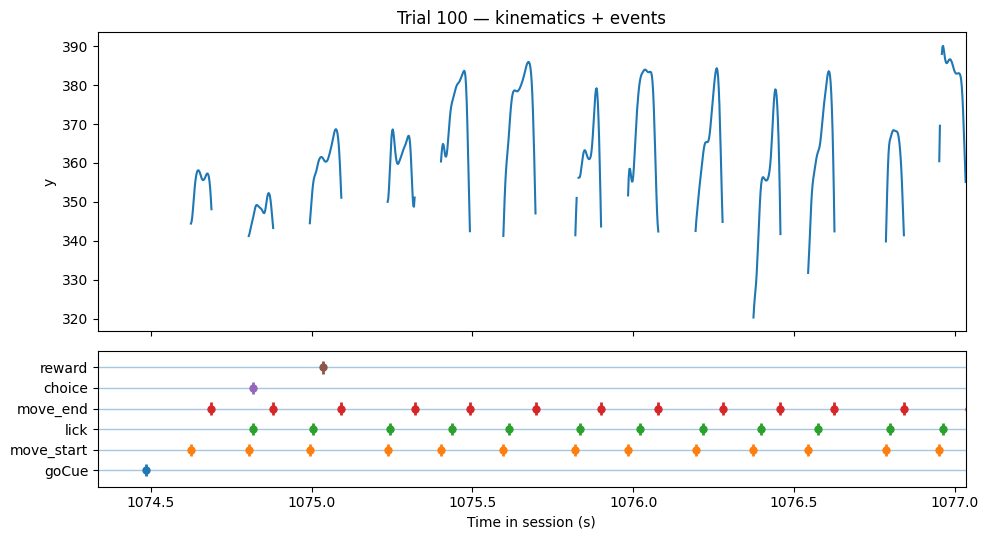

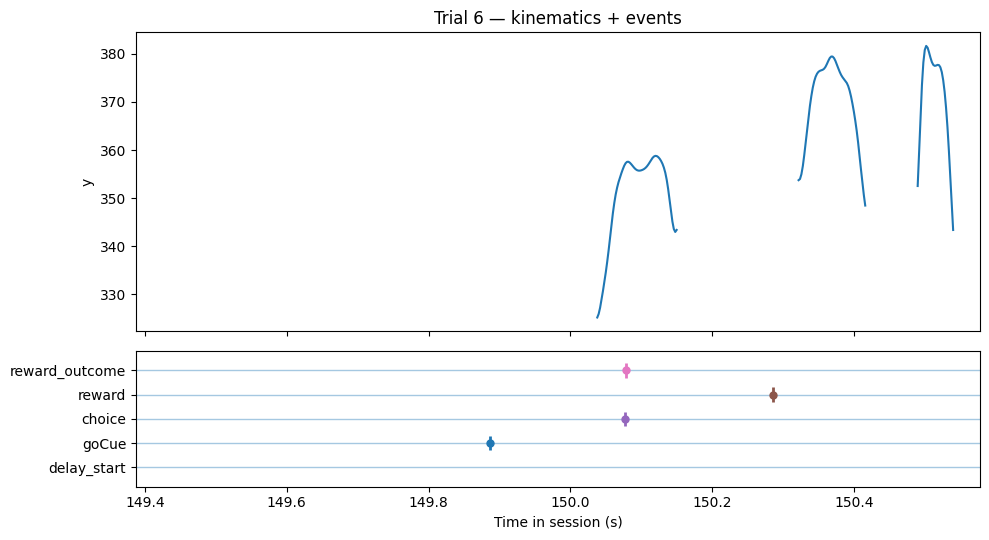

In [4]:
session = Path("/root/capsule/scratch/session_analysis_halloween/behavior_716325_2024-05-31_10-31-14")
base_dirs = [
    Path("/root/capsule/scratch/session_analysis_halloween")
]
sdir = find_session_dir(session, roots=base_dirs)
data = load_intermediate_data(sdir)  # {movs,trials,licks,kins,events}
movs   = data["movs"]
trials = data["trials"]
licks  = data["licks"]
kins   = data["kins"]
evnts  = data["events"]

timeline = build_timeline(trials, evnts, licks, movs)

# “animal perspective” style window: goCue → reward
plot_trial_with_kins(
    trial_id=100,
    kins=kins,
    timeline=timeline,
    event_order=["goCue", "move_start", "lick", "move_end", "choice", "reward"],
    window_events=("goCue", "reward"),
    pad_before=0.15,
    pad_after=2.0,
)

# or “task events” style: delay → reward_outcome
plot_trial_with_kins(
    trial_id=6,
    kins=kins,
    timeline=timeline,
    event_order=["delay_start", "goCue", "choice", "reward", "reward_outcome"],
    window_events=("goCue", "reward_outcome"),
    pad_before=.5,
    pad_after=.5,
)
